In [29]:
# Import required libraries and define dataset paths

import os
from glob import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split

DATA_ROOT = "../data"

# Define subdirectory paths
TRAIN_FLOODED_IMG = os.path.join(DATA_ROOT, "Train/Labeled/Flooded/image")
TRAIN_FLOODED_MASK = os.path.join(DATA_ROOT, "Train/Labeled/Flooded/mask")

TRAIN_NONFLOODED_IMG = os.path.join(DATA_ROOT, "Train/Labeled/Non-Flooded/image")
TRAIN_NONFLOODED_MASK = os.path.join(DATA_ROOT, "Train/Labeled/Non-Flooded/mask")

In [30]:
# Load image and mask file paths

train_images = sorted(
    glob(os.path.join(TRAIN_FLOODED_IMG, "*.jpg")) +
    glob(os.path.join(TRAIN_NONFLOODED_IMG, "*.jpg"))
)

train_masks = sorted(
    glob(os.path.join(TRAIN_FLOODED_MASK, "*.png")) +
    glob(os.path.join(TRAIN_NONFLOODED_MASK, "*.png"))
)

print("Total labeled images:", len(train_images))
print("Total labeled masks :", len(train_masks))

Total labeled images: 398
Total labeled masks : 398


In [31]:
# Split labeled dataset into training and validation sets (80/20 split)

train_imgs_split, val_imgs_split, train_masks_split, val_masks_split = train_test_split(
    train_images, train_masks, test_size=0.2, random_state=42
)

print("Training images:", len(train_imgs_split))
print("Validation images:", len(val_imgs_split))

Training images: 318
Validation images: 80


In [32]:
# Resize images, convert to tensor, and scale to [0,1]
# Masks use nearest-neighbor interpolation and integer labels

import torchvision.transforms.functional as TF
import torch

IMG_SIZE = 256

def preprocess_image(img):
    img = TF.resize(img, (IMG_SIZE, IMG_SIZE))
    img = TF.to_tensor(img)
    return img

def preprocess_mask(mask):
    mask = TF.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=TF.InterpolationMode.NEAREST)
    mask = torch.from_numpy(np.array(mask)).long()
    return mask

In [33]:
# Simple augmentation: horizontal and vertical flips

def augment(img, mask):
    if random.random() > 0.5:
        img = TF.hflip(img)
        mask = torch.flip(mask, dims=[1])
    if random.random() > 0.5:
        img = TF.vflip(img)
        mask = torch.flip(mask, dims=[0])
    return img, mask

In [34]:
# Test preprocessing on one sample image-mask pair

idx = random.randint(0, len(train_imgs_split)-1)

img_raw = Image.open(train_imgs_split[idx])
mask_raw = Image.open(train_masks_split[idx])

img_p = preprocess_image(img_raw)
mask_p = preprocess_mask(mask_raw)

print("Image shape after preprocessing:", img_p.shape)
print("Mask shape after preprocessing:", mask_p.shape)

Image shape after preprocessing: torch.Size([3, 256, 256])
Mask shape after preprocessing: torch.Size([256, 256])


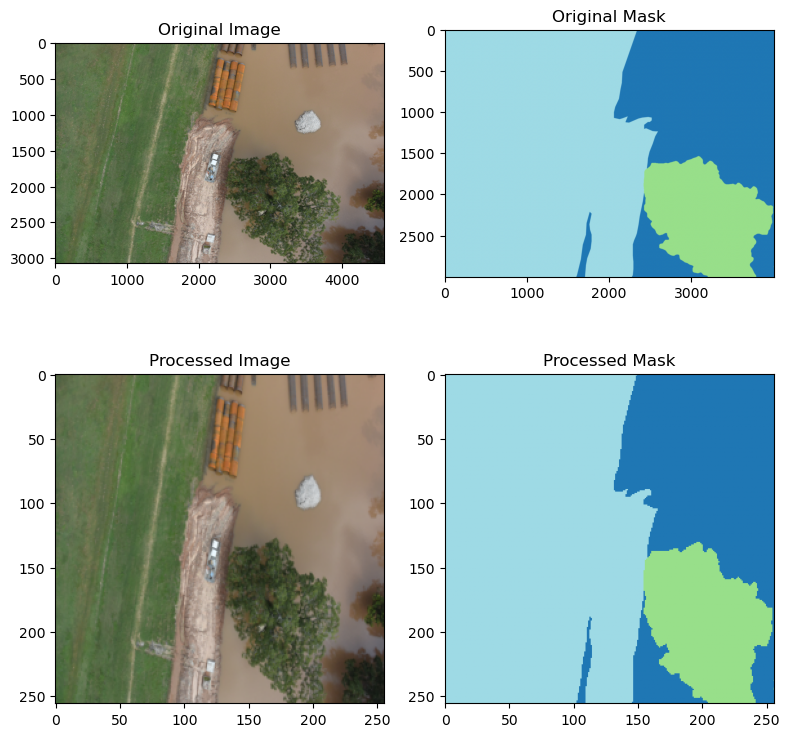

In [35]:
# Compare original and resized+normalized images

fig, ax = plt.subplots(2, 2, figsize=(8, 8))

ax[0][0].imshow(img_raw)
ax[0][0].set_title("Original Image")

ax[0][1].imshow(mask_raw, cmap='tab20')
ax[0][1].set_title("Original Mask")

ax[1][0].imshow(img_p.permute(1,2,0))
ax[1][0].set_title("Processed Image")

ax[1][1].imshow(mask_p, cmap='tab20')
ax[1][1].set_title("Processed Mask")

plt.tight_layout()
plt.show()

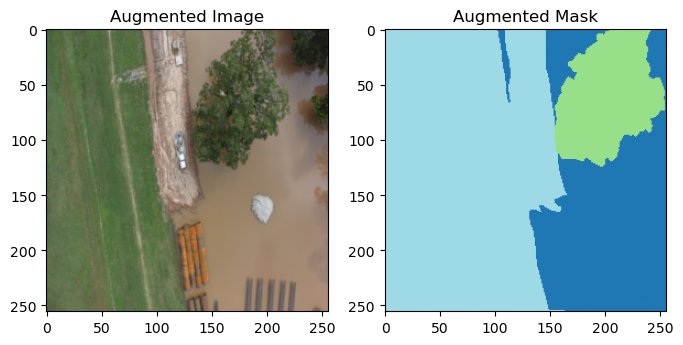

In [36]:
# Apply augmentation and visualize results

img_aug, mask_aug = augment(img_p.clone(), mask_p.clone())

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(img_aug.permute(1,2,0))
ax[0].set_title("Augmented Image")
ax[1].imshow(mask_aug, cmap='tab20')
ax[1].set_title("Augmented Mask")
plt.show()

In [38]:
# Save preprocessed and augmented images

import os
from tqdm import tqdm
from PIL import Image
import torchvision.transforms.functional as TF

processed_root = "../data/Processed"
os.makedirs(os.path.join(processed_root, "train_images"), exist_ok=True)
os.makedirs(os.path.join(processed_root, "train_masks"), exist_ok=True)
os.makedirs(os.path.join(processed_root, "val_images"), exist_ok=True)
os.makedirs(os.path.join(processed_root, "val_masks"), exist_ok=True)

def save_preprocessed_images(image_paths, mask_paths, out_img_dir, out_mask_dir, do_augment=False):
    for i, (img_path, mask_path) in enumerate(tqdm(zip(image_paths, mask_paths), total=len(image_paths))):
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        # Preprocess using your existing functions
        img_tensor = preprocess_image(img)
        mask_tensor = preprocess_mask(mask)

        # Optional: apply basic augmentation every other image
        if do_augment and (i % 2 == 0):
            img_tensor, mask_tensor = augment(img_tensor, mask_tensor)

        # Convert tensors back to PIL for saving
        img_out = TF.to_pil_image(img_tensor)
        mask_out = Image.fromarray(mask_tensor.numpy().astype("uint8"))

        fname = os.path.basename(img_path)
        mask_fname = os.path.splitext(fname)[0] + ".png"

        img_out.save(os.path.join(out_img_dir, fname), format="JPEG", quality=95)
        mask_out.save(os.path.join(out_mask_dir, mask_fname))

# Run for train (with augmentation)
save_preprocessed_images(
    train_imgs_split,
    train_masks_split,
    os.path.join(processed_root, "train_images"),
    os.path.join(processed_root, "train_masks"),
    do_augment=True
)

# Run for validation (no augmentation)
save_preprocessed_images(
    val_imgs_split,
    val_masks_split,
    os.path.join(processed_root, "val_images"),
    os.path.join(processed_root, "val_masks"),
    do_augment=False
)

print("✅ All preprocessed and augmented images saved successfully!")

100%|███████████████████████████████████████████| 80/80 [00:09<00:00,  8.15it/s]

✅ All preprocessed and augmented images saved successfully!


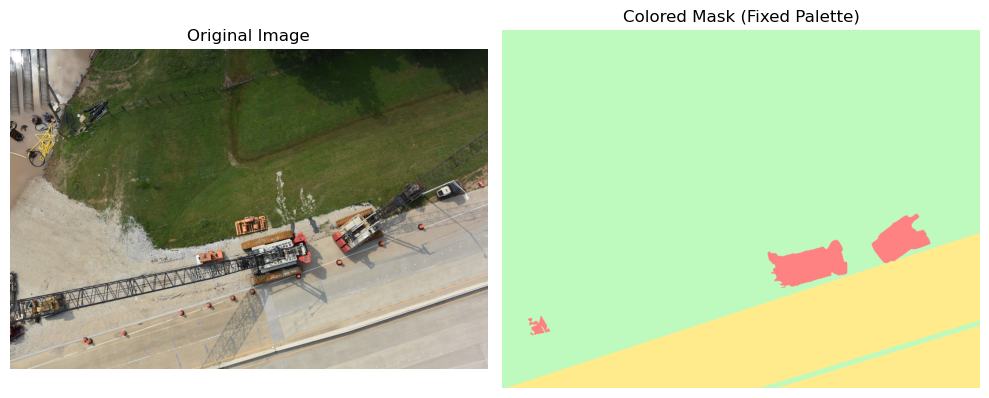

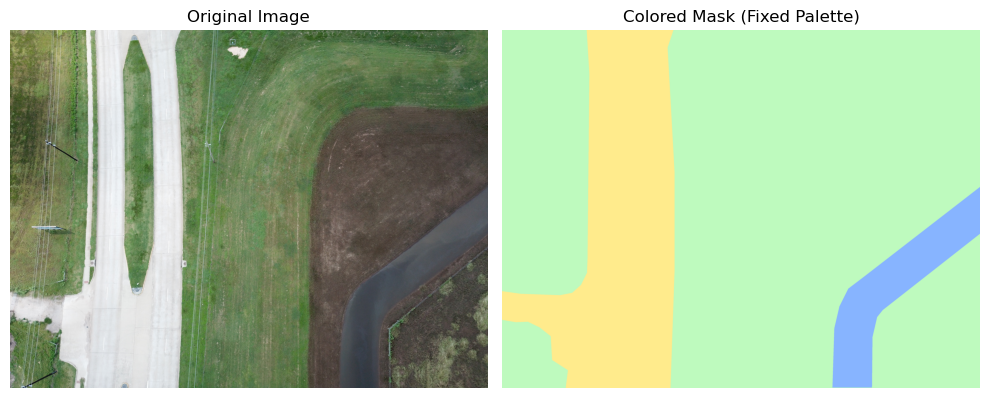

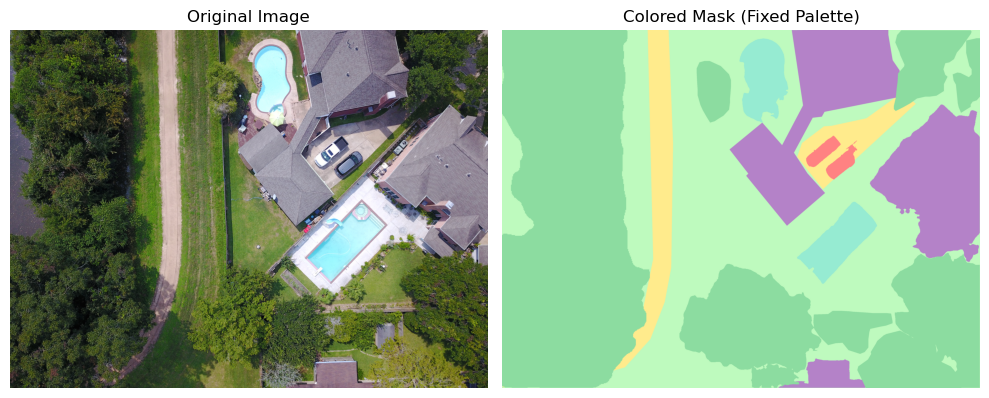

In [46]:
# Class Mapping and Color Visualization

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

# Class name mapping
FLOODNET_CLASSES = {
    0: "Background",
    1: "Building Flooded",
    2: "Building Non-Flooded",
    3: "Road Flooded",
    4: "Road Non-Flooded",
    5: "Water",
    6: "Tree",
    7: "Vehicle",
    8: "Pool",
    9: "Grass"
}

# Fixed RGB color palette 
FLOODNET_COLORS = {
    0: (30, 30, 30),         # Background - dark gray
    1: (102, 153, 255),      # Building Flooded - soft blue
    2: (180, 130, 200),      # Building Non-Flooded - lavender
    3: (120, 210, 230),      # Road Flooded - light cyan
    4: (255, 235, 140),      # Road Non-Flooded - pale yellow
    5: (135, 180, 255),      # Water - sky blue
    6: (140, 220, 160),      # Tree - soft green
    7: (255, 130, 130),      # Vehicle - muted red
    8: (150, 235, 210),      # Pool - mint green
    9: (190, 250, 190)       # Grass - pale green
}

def decode_segmap(mask, color_dict=FLOODNET_COLORS):
    """Convert integer mask to RGB color image."""
    h, w = mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for cls_id, color in color_dict.items():
        rgb[mask == cls_id] = color
    return Image.fromarray(rgb)

# Visualize a few random samples with fixed color palette

def show_colored_samples(n=3):
    for _ in range(n):
        idx = random.randint(0, len(train_masks_split) - 1)
        
        img = np.array(Image.open(train_imgs_split[idx]).convert("RGB"))
        mask = np.array(Image.open(train_masks_split[idx]))
        colored_mask = decode_segmap(mask)

        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(img)
        ax[0].set_title("Original Image")
        ax[0].axis('off')

        ax[1].imshow(colored_mask)
        ax[1].set_title("Colored Mask (Fixed Palette)")
        ax[1].axis('off')

        plt.tight_layout()
        plt.show()

# Display 3 random samples
show_colored_samples(3)

In [47]:
# Preprocessing and Augmentation Summary

# - Loaded the FloodNet UAV dataset (10 semantic classes) with aligned RGB images and masks
# - Verified image–mask correspondence and dataset integrity
# - Checked class distribution across masks to understand dataset imbalance
# - Split the labeled dataset into 80% training and 20% validation sets
# - Resized all samples to 256x256 for training efficiency
# - Converted images to tensors and normalized pixel values to [0,1]
# - Converted masks to long integer tensors using nearest-neighbor interpolation to preserve class IDs
# - Applied basic data augmentation (horizontal and vertical flips) to improve generalization
# - Verified preprocessing and augmentation visually using random samples
# - Displayed class percentage distributions for per-image analysis
# - Saved all preprocessed and augmented images and masks into structured directories:
#   ../data/Processed/train_images, train_masks, val_images, val_masks
# - Set a fixed colour palette for every class for intuitive analysis (To be used in visualization)

# Next Steps in the Project

# 1. Implement a PyTorch Dataset class to load preprocessed images and masks dynamically
# 2. Create DataLoader objects for efficient mini-batch training
# 3. Define the U-Net architecture for semantic segmentation
# 4. Configure the loss function (Weighted CrossEntropyLoss) and optimizer (Adam)
# 5. Train the model on the processed FloodNet data
# 6. Evaluate performance using IoU and Dice score metrics
# 7. Visualize model predictions and compare them with ground truth masks